<a href="https://colab.research.google.com/github/mima25/timeseries_ml/blob/master/NZ_AI_workshop2019_TimeseriesRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction from timeseries data
In this notebook, we want to showcase how machine learning and deep learning can be used to predict a quantity (say, yield) from timeseries data (say, sensor measurements). The lessons learned apply equally to different tasks where timeseries (or any sequential data) is involved.

Rather than struggle with a real-life dataset, in this notebook we'll go through the steps of creating a dummy dataset. The advantage of doing this is that we **know** there's a signal in the data, which we should thus be able to pick up using a machine learning (ML) or deep learning (DL) model.

Content of the notebook:

* Create a random dataset with some features having sinusoidal nature and some with sigmoidal nature. Samples should have different lengths just to make things a bit more challenging, and we include plenty of noise as well.
* Implement a known non-linear target based different metadata of the generated sinusoidal/sigmoid curves and the noise.
* Try to predict our known targets using traditional ML
* Try to predict out known targets using DL

A note of caution though; **real life can be much more messy** than what we are going to do in this notebook.

## Notebook Settings

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.preprocessing import sequence

sns.set(style="darkgrid", color_codes=True)
%matplotlib inline

# Data Generation
For data generation, we will implement a `DataGenerator` class, which will allow us to create datasets of arbitrary size and complexity. 

In [0]:
class DataGenerator(object):

    def __init__(self, n_samples=1000):
        
        # Number of batches
        self.n_samples = n_samples
        
        # Info on batch length
        self.avg_batch_length = 200
        self.std_batch_length = 20
        
        # Sigmoid features
        self.sigmoid_n_features = 3   
        self.sigmoid_amplitude_avg = 3
        self.sigmoid_amplitude_std = 2   
        self.sigmoid_noise_avg = 20
        self.sigmoid_noise_std = 20

        # Sinus features
        self.sin_n_features = 3
        self.sin_amplitude_avg = 5
        self.sin_amplitude_std = 2        
        self.sin_frequency_avg = 2
        self.sin_frequency_std = 1
        self.sin_noise_avg = 20
        self.sin_noise_std = 20
        
        # Rate of missing values in the dataset
        self.nan_rate = 0.05
        
        # Generate batches
        self.metadata = []
        self.batches = []
        for _ in range(self.n_samples):
            data, meta = self._create_batch()
            self.batches.append(data)
            self.metadata.append(meta)
            
        # Put metadata into a dataframe
        self.metadata = pd.DataFrame(self.metadata)
        
        # Generate target
        self.target = self._create_target()
        
            
    def _create_batch(self):
        """Create a batch. Return values & metadata"""
        
        # Store batches in this dictionary
        batch, meta = {}, {}
        
        # Calculate batch length
        l = int(np.random.normal(self.avg_batch_length, self.std_batch_length))
        
        # Generate sinusoidal features
        ##############################
        x = np.linspace(-np.pi, np.pi, l)
        for i in range(self.sin_n_features):
            
            # Metadata for this sinus curve
            amplitude = np.random.normal(self.sin_amplitude_avg, self.sin_amplitude_std)
            frequency = np.random.normal(self.sin_frequency_avg, self.sin_frequency_std)
            noise = np.random.normal(self.sin_noise_avg, self.sin_noise_std)
            shift = np.random.rand()*np.pi
            
            # Noise is in percent of aplitude
            noise = np.abs(amplitude * (noise / 100))
            
            # Calculate sinus curve
            batch['sin-{}'.format(i)] = np.sin(x * frequency + shift) * amplitude + np.random.normal(0, noise, size=l)
            
            # Save metadata
            meta['sin-amplitude-{}'.format(i)] = amplitude
            meta['sin-frequency-{}'.format(i)] = frequency
            meta['sin-noise-{}'.format(i)] = noise
            meta['sin-shift-{}'.format(i)] = shift
            
        # Generate sigmoid features
        ##############################
        x = np.linspace(-5, 5, l)
        for i in range(self.sigmoid_n_features):
            
            # Metadata for this sinus curve
            amplitude = np.random.normal(self.sigmoid_amplitude_avg, self.sigmoid_amplitude_std)
            noise = np.random.normal(self.sigmoid_noise_avg, self.sigmoid_noise_std)
            
            # Noise is in percent of amplitude again
            noise = np.abs(amplitude * (noise / 100))
            
            # Calculate sigmoid curve
            batch['sigmoid_{}'.format(i)] = amplitude / (1 + np.exp(-x)) + np.random.normal(0, noise, size=l)
            
            # Save metadata
            meta['sigmoid-amplitude-{}'.format(i)] = amplitude
            meta['sigmoid-noise-{}'.format(i)] = noise
        
        return pd.DataFrame(batch), pd.Series(meta)
    
    def _create_target(self):
        """Based on metadata information, generate the target variable, which is a polynomial combination of all the features"""
        
        # Generate polynomial features and scale everything so it's on the same scale
        self.feature_generator = Pipeline([
            ('polynomial', PolynomialFeatures(degree=3)), 
            ('scale', StandardScaler())
        ])
        self.features = self.feature_generator.fit_transform(self.metadata)
        
        # Weight each column differently (both negative and positive weights), and sum across columns
        self.importances = np.random.laplace(0, 0.5, size=self.features.shape[1])

        # Set some of the importances to 0
        self.importances *= np.random.choice([0, 1], size=self.features.shape[1], p=[0.90, 0.1])
        
        # Multiply each column with its weight, and add up all together (i.e. matrix * vector)
        target = self.features.dot(self.importances)
        
        # Mean-std scale target & return it
        self.target_scaler = StandardScaler()
        return self.target_scaler.fit_transform(target.reshape(-1, 1)).ravel()
    
    def visualize_feature_weights(self):
        """Visualize the importance of each feature"""
        pd.DataFrame({
            'feature': self.feature_generator.steps[0][1].get_feature_names(datagen.metadata.columns),
            'weight': self.importances,
            'abs_weight': np.abs(self.importances)
        }).set_index('feature').sort_values('abs_weight', ascending=False).weight.iloc[0:20].plot(kind='bar', figsize=(20, 5))
        plt.show()
            
    def visualize_random_batches(self, n=1):
        """Visualize features for n batch"""
        
        # Go through n batches
        for batch_id in np.random.choice(range(self.n_samples), size=n, replace=False):
        
            # Sample a random batch from our list of batches            
            batch = self.batches[batch_id]

            # Visulize all the sinus features
            fig, axes = plt.subplots(1, 2, figsize=(20, 5))
            batch[[c for c in batch.columns if 'sigmoid' in c]].plot(ax=axes[1])
            batch[[c for c in batch.columns if 'sin' in c]].plot(ax=axes[0])
            fig.suptitle('Features of Batch {}. Target yield: {}'.format(batch_id, self.target[batch_id]))
            plt.show()

    def get_ml_data(self):
        """Get data prepared for traditional ML algorithms"""

        # Create X from different statistics of the timeseries
        Xs = [
            np.array([batch.mean().values for batch in self.batches]), # means
            np.array([batch.std().values for batch in self.batches]), # stds
            np.array([batch.min().values for batch in self.batches]), # min
            np.array([batch.max().values for batch in self.batches]) # max
        ]
        X = np.concatenate(Xs, axis=1)
        y = self.target

        # Create a dataframe version of X with column names
        X = pd.DataFrame(X, columns=[c+t for t in ['mean', 'std', 'min', 'max'] for c in self.batches[0].columns])
        return X, y 

    def get_dl_data(self):
        """Get data prepared for DL"""
        X = sequence.pad_sequences([batch.values for batch in self.batches])
        y = self.target
        return X, y

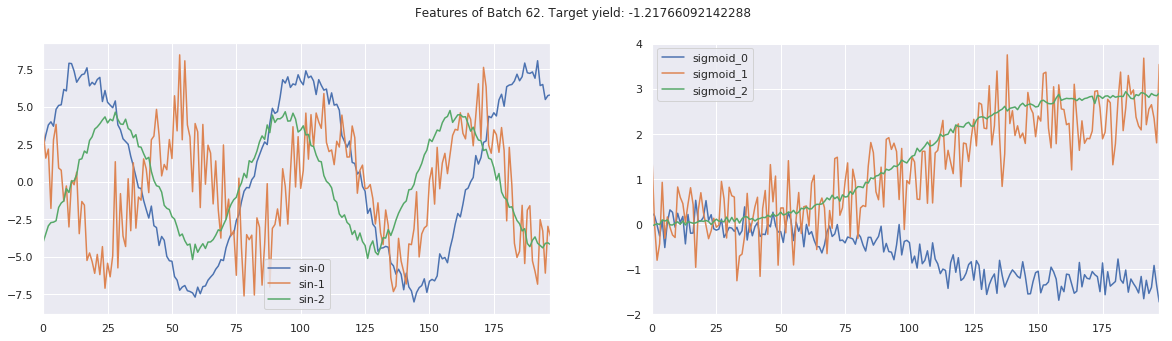

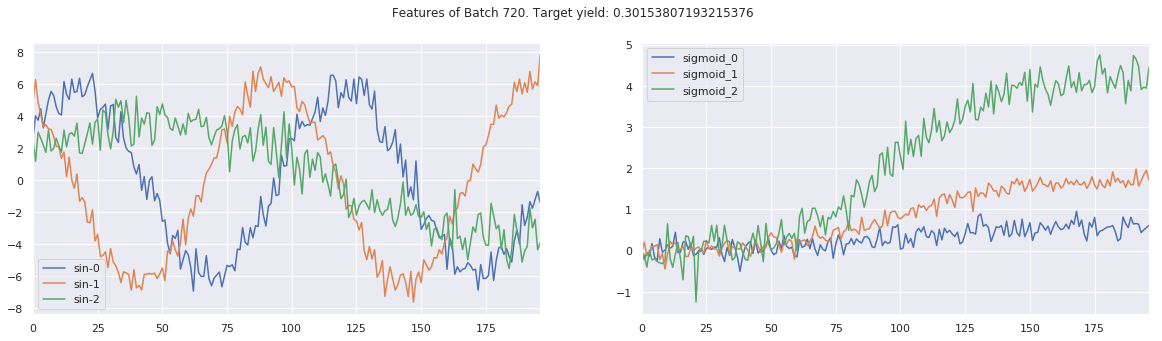

In [3]:
# Instantiate the data manager which will create our data
datagen = DataGenerator()

# Visualize the feature for a few batches
datagen.visualize_random_batches(n=2)

# Visualize the importance of the different features in the dataset for target pred
#datagen.visualize_feature_weights()

# Traditional Machine Learning
Before we jump into DL, it is always good first to establish a baseline using traditional ML techniques. Afterall, if the more complex DL methods cannot beat simple models, then there is no point in doing them in the first place. We will evaluate our models using cross-validation, i.e. see the following.

![alt text](http://s5047.pcdn.co/wp-content/uploads/2015/06/07_cross_validation_diagram.png)

Taking all our test predictions, we can evaluate an overall out-of-sample score for a given model

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_results(true, pred):
    # Print baseline error
    print('RMSE = {:.3f}'.format(np.sqrt(mean_squared_error(true, pred))))
    print('MSE = {:.3f}'.format(mean_squared_error(true, pred)))
    print('MAE = {:.3f}'.format(mean_absolute_error(true, pred)))
    print('R2 = {:.3f}'.format(r2_score(true, pred)))

    # Show predictions vs. measures
    ax = sns.jointplot(true, pred, kind="reg", color="r", height=7)
    ax.ax_joint.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.show()

## Linear Regression
The first model we will try to run is linear regression; primarily because it is fast. Note however that a linear model generally has some assumptions about the data, 1) that there is a linear relationship between features and target, 2) no collinearity between features, 3) homoscedasticity of the error, 4) autocorrelation in the residuals etc. If the data does not immediately fulfill these criteria, the performance of the model may suffer - however, in our case our generated dataset is luckily quite well-behaved, and in any case we only consider out-of-sample predictions in order to ensure that we get a realistic picture of our model performance.

Because we have some many features, we will use a Lasso linear model which uses L1 regularization during the optimization, which makes it very good at only focusing on features of interest ([see here](https://stats.stackexchange.com/questions/218208/what-are-the-advantages-of-stepwise-regression/218223#218223) for explanation). We do however need to tune the regularization factor of the Lasso model, which we also do with cross-validation. In order to ensure that we do not overfit on our data, we do what is known as "nested crossvalidation":

![alt text](https://mlfromscratch.com/content/images/2019/05/nested_cv.png)


RMSE = 0.738
MSE = 0.545
MAE = 0.546
R2 = 0.455


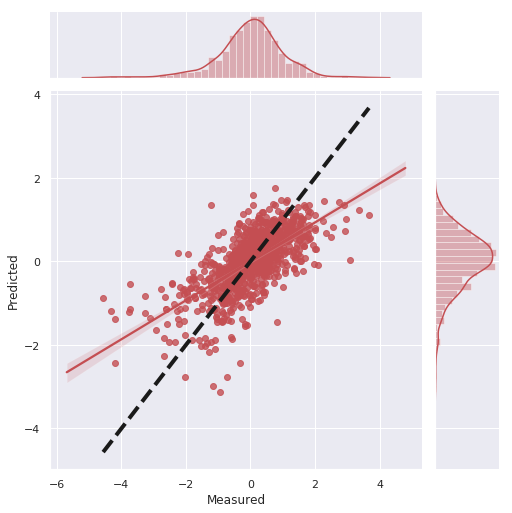

In [0]:
X, y = datagen.get_ml_data()

regr = LassoCV(cv=10)
pred = cross_val_predict(regr, X, y, cv=10, n_jobs=-1)
evaluate_results(y, pred)

## Random Forest Regression
A random forest model usually works really well for a lot of problems, and it's much more forgiving when it comes to what it takes as input; i.e. it is agnostic to feature scales, can more easily deal with categorical variables in the tree structure, etc.

<img src='https://miro.medium.com/max/2612/0*f_qQPFpdofWGLQqc.png' width='400px'/>

For our "nice" dataset we don't expect a big improvement from the random forest model, but it might improve our predictions a little bit, since the nature of the model allows for non-linear interactions that might not be captured in the linear model.

RMSE = 0.709
MSE = 0.503
MAE = 0.525
R2 = 0.497


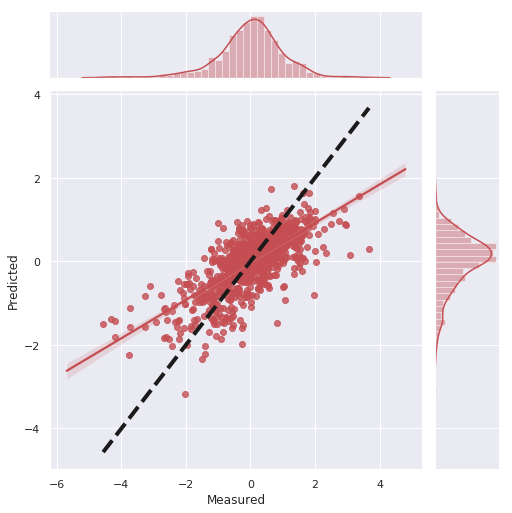

In [0]:
regr = ExtraTreesRegressor(n_estimators=100)
pred = cross_val_predict(regr, X, y, cv=10, n_jobs=-1)
evaluate_results(y, pred)

## LightGBM model
This is a model (together with analogs like xgBoost and catBoost), which often wins competitions. The basic idea of gradient boosting is the following:

* Fit a model to the data: F1(x) = y
* Fit a model to the residuals, h1(x) = y - F1(x)
* Create a new improved model: F2(x) = F1(x) + h1(x)
* Repeat above...

Thereby creating a much stronger learner.

RMSE = 0.694
MSE = 0.481
MAE = 0.519
R2 = 0.519


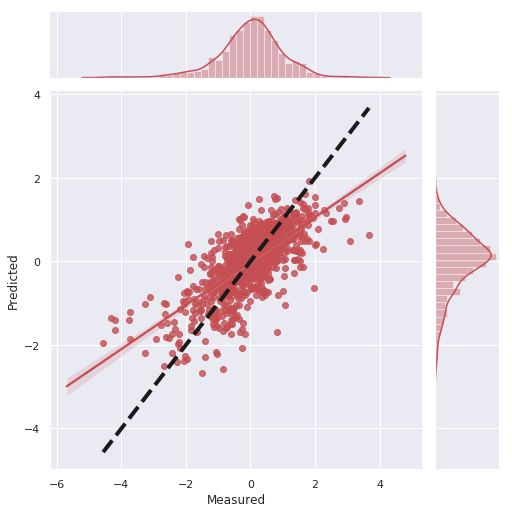

In [0]:
import lightgbm as lgb

regr = lgb.LGBMRegressor(objective='regression', metric='rmse', n_jobs=1, verbose=0)
pred = cross_val_predict(regr, X, y, cv=10, n_jobs=-1)
evaluate_results(y, pred)

## Interpreting the model using SHAP
Traditionally linear models or random forests are interpreted using the linear coefficients and the "feature importances". However, for random forest models feature importances can be inconsistent, and therefore generally the recommended approach [is to instead use SHAP](https://arxiv.org/abs/1802.03888). There are various alternatives to SHAP, e.g. LIME, but for most consistent and reliable feature importances, [SHAP is recommended](https://arxiv.org/abs/1705.07874). Luckily, there is a SHAP library in python, which is very easy to use for any given model.

In [0]:
! pip install shap

     |████████████████████████████████| 245kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.30.1-cp36-cp36m-linux_x86_64.whl size=360453 sha256=d38919e59e964c345867925feeab7b893b5f210856d07571f73c9bba0af6fb77
  Stored in directory: /root/.cache/pip/wheels/62/94/5e/feb9af12d63a719a32266a29ca564b4dc37b4755052aca6859
Successfully built shap


In [0]:
import shap

model = lgb.LGBMRegressor(objective='regression', metric='rmse', n_jobs=1, verbose=0)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [0]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

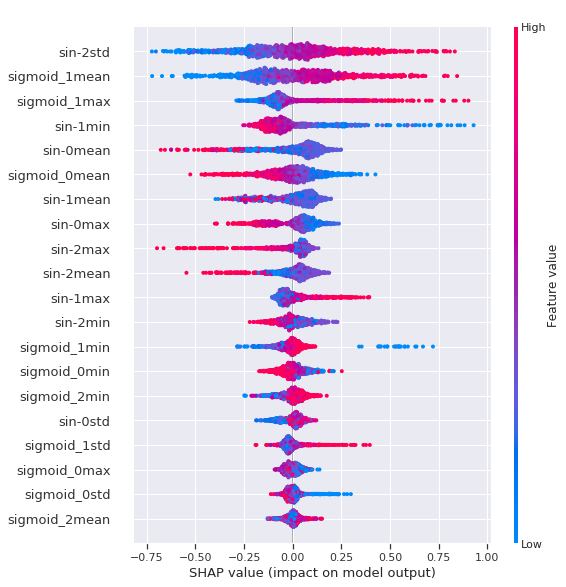

In [0]:
# summarize the effects of all the features
shap.initjs()
shap.summary_plot(shap_values, X)

--------------------------------------------

# Deep Learning
Now that we've gone through a few traditional ML approaches, let us see what we can do with deep learning. In the most simple case, a neural network is simply about setting up a network of nodes which pass information from inputs to outputs using non-linear math functions:

<img src='https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/example_network.svg' width='300px'/><br />
* <small><i>Taken from: https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/</i></small><br />

However, when we are processing sequences (timeseries, proteins, etc.) or 2D/3D images and videos, we typically use different architectures, including but not limited to recurrent networks, convolutional networks, transformers, etc. In this example we will use a so-called Long-Short Term Memory (LSTM) module, which is a recurrent neural network. 

<img src='https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png' width='600px' /><br />
* <small><i>Taken from: https://colah.github.io/posts/2015-08-Understanding-LSTMs/</i></small>

To learn more about deep learning, we highly recommend the courses offered on [deeplearning.ai](https://www.deeplearning.ai/deep-learning-specialization/)

## Splitting data into train & test

In [0]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Generate a new dataset with 10X the data
datagen = DataGenerator(n_samples=10000)

# Get the raw data which we will use as input for the model
X_dl, y_dl = datagen.get_dl_data()

# Split into train & test
cv = KFold(n_splits=10)
train_idx, test_idx = next(cv.split(y_dl))
X_dl_train, X_dl_test = X_dl[train_idx], X_dl[test_idx]
y_dl_train, y_dl_test = y_dl[train_idx], y_dl[test_idx]

# Get number of "features" and timesteps
n_features = X_dl.shape[2]
n_timesteps = X_dl.shape[1]

## Establish baseline

RMSE = 0.533
MSE = 0.284
MAE = 0.376
R2 = 0.711


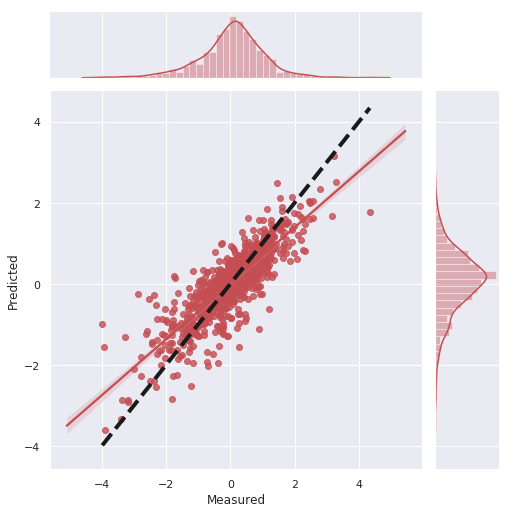

In [0]:
import lightgbm as lgb

# Get ML data split into train & test
X_ml, y_ml = datagen.get_ml_data()
X_ml_train, X_ml_test = X_ml.iloc[train_idx], X_ml.iloc[test_idx]
y_ml_train, y_ml_test = y_ml[train_idx], y_ml[test_idx]

# Fit regressor on train, predict & evaluate on test
regr = lgb.LGBMRegressor(objective='regression', metric='rmse', n_jobs=1, verbose=0)
regr.fit(X_ml_train, y_ml_train)
pred = regr.predict(X_ml_test)
evaluate_results(y_ml_test, pred)

## Creating the LSTM model

In [0]:
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(10, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), input_shape=(n_timesteps, n_features, )))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 280, 20)           1360      
_________________________________________________________________
dense (Dense)                (None, 280, 10)           210       
_________________________________________________________________
flatten (Flatten)            (None, 2800)              0         
______________________________________________

## Training the model

In [0]:
!pip install livelossplot
from livelossplot.keras import PlotLossesCallback

Using TensorFlow backend.


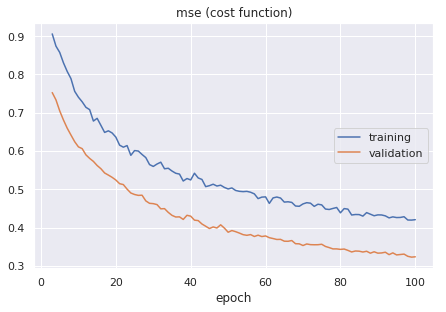

mse (cost function):
training   (min:    0.420, max:    1.098, cur:    0.421)
validation (min:    0.323, max:    0.899, cur:    0.324)
9000/9000 [==============================] - 9s 1ms/sample - loss: 0.4206 - val_loss: 0.3237
RMSE = 0.569
MSE = 0.324
MAE = 0.421
R2 = 0.670


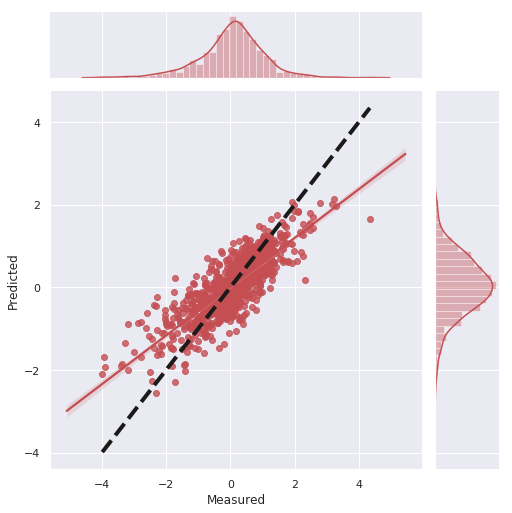

In [0]:
model.fit(
    X_dl_train, y_dl_train, 
    batch_size=1024, 
    epochs=100, 
    validation_data=(X_dl_test, y_dl_test), 
    callbacks=[PlotLossesCallback(dynamic_x_axis=True)]
)

pred = model.predict(X_dl_test)
evaluate_results(y_dl_test, pred.flatten())

## Interpreting the model using SHAP

In [0]:
import shap

# We use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_dl_train[:100])

# Explain the first 10 predictions
# Explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_dl_test[:50])

# Show timeseries importances
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][1], datagen.batches[0].columns.values)

----------------------------------------------------------------
# Advanced Topics

## Feature Selection
Stay away from most feature selection algorithms unless you have computational power to perform the selection in a nested cross-validated manner (which is expensive). One easily risks creating an overfitted CV score. One good option for performing feature selection without overfitting is Boruta.

In [0]:
!pip install Boruta

In [0]:
datagen = DataGenerator(n_samples=1000)
X, y = datagen.get_ml_data()

RMSE = 0.702
MSE = 0.493
MAE = 0.513
R2 = 0.507


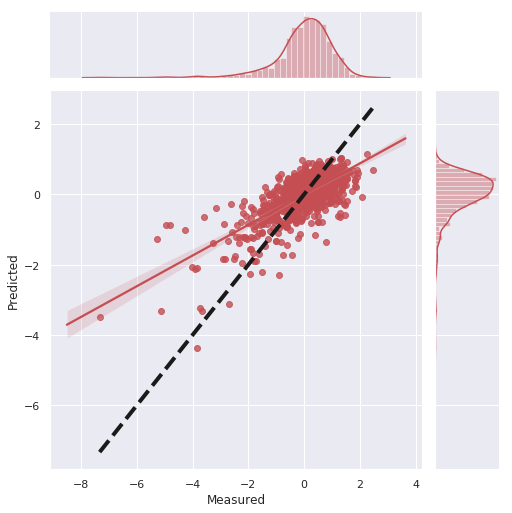

In [0]:
from sklearn.base import clone 
pred = cross_val_predict(ExtraTreesRegressor(n_estimators=100), X, y, cv=10, n_jobs=-1)
evaluate_results(y, pred)

RMSE = 0.699
MSE = 0.488
MAE = 0.514
R2 = 0.512


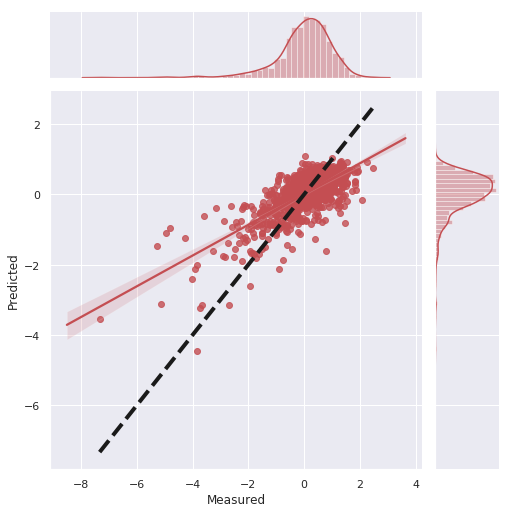

In [0]:
from boruta import BorutaPy

# Perform feature selection
feat_selector = BorutaPy(ExtraTreesRegressor(), n_estimators='auto', verbose=0, random_state=1)
feat_selector.fit(X.values, y)
X_filtered = feat_selector.transform(X.values)

# Get CV evaluation
pred = cross_val_predict(ExtraTreesRegressor(n_estimators=100), X_filtered, y, cv=10, n_jobs=-1)
evaluate_results(y, pred)

## Model Tuning
Generally, random cv search in hyperparameter space with sklearn can work very well, but we also have the option of using a bayesian search algorithm from scikit-optimize library, which allows us to better specify the search space in terms of the distribution on which to sample the different parameters. Simply increate the number for `n_iter` to search for longer

In [0]:
!pip install scikit-optimize
!pip install scikit-learn==0.20.3

In [0]:
from skopt import BayesSearchCV
import lightgbm as lgb

datagen = DataGenerator(n_samples=1000)
X, y = datagen.get_ml_data()

bayes_cv_tuner = BayesSearchCV(
    estimator = lgb.LGBMRegressor(
        objective='regression',
        metric='mse',
        n_jobs=1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'num_leaves': (2, 100),      
        'max_depth': (0, 50),
        'min_child_samples': (0, 50),
        'max_bin': (100, 1000),
        'subsample': (0.01, 1.0, 'uniform'),
        'subsample_freq': (0, 10),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'min_child_weight': (0, 10),
        'subsample_for_bin': (100000, 500000),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        'n_estimators': (50, 100),
    },    
    scoring = 'neg_mean_squared_error',
    cv = 3,
    n_jobs = -1,
    n_iter = 20,
    verbose = 0,
    refit = True
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest MSE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

result = bayes_cv_tuner.fit(X.values, y, callback=status_print)

## Convolutional Network
LSTMs train horribly slow on timeseries data, and usually the same or better results can actually be achieved much faster using 1D convolutional networks. Run this cell after having run the LSTM cells, so that results can be compared. The following network has not be optimized for the task at hand, but serves to introduce advanced concepts that can make a CNN model perform better than the LSTM baseline:

* Improved optimizer RAdam from: https://arxiv.org/abs/1908.03265
* Lookahead-enhancement for optimizer: https://arxiv.org/abs/1907.08610v1
* Dilated convolutions from augmented wavenet: https://arxiv.org/abs/1703.04691
* SeLU activation functions: https://arxiv.org/abs/1706.02515
* SeriesNet architectural ideas: https://ieeexplore.ieee.org/document/8489522

In [0]:
!pip install keras-rectified-adam keras-lookahead

In [0]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Dense, Flatten
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

from keras_radam import RAdam
from keras_lookahead import Lookahead


def residual_block(nb_filter, filter_length, dilation, l2_layer_reg):
    def f(input_):        
        residual =    input_        
        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, 
                      dilation_rate=dilation, 
                      activation='linear', padding='same', use_bias=False,
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, 
                      seed=42), kernel_regularizer=l2(l2_layer_reg))(input_)                    
        layer_out =   Activation('selu')(layer_out)        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05), 
                      kernel_regularizer=l2(l2_layer_reg))(layer_out)        
        network_in =  Conv1D(1,1, activation='linear', use_bias=False, 
                      kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05), 
                      kernel_regularizer=l2(l2_layer_reg))(layer_out)                      
        network_out = Add()([residual, network_in])        
        return network_out, skip_out    
    return f


def build_fn(n_timesteps):

    input = Input(shape=(n_timesteps,n_features))

    reg = 0.001
    filters = 32
    dropout = 0.1
    loss = 'mae'
    layers = 7
    
    x = input
    skip_connects = []
    for i in range(layers):
        dilation = 2**i
        print(">> CNN block with dilation: ", dilation)
        x, skip = residual_block(filters,2,dilation,reg)(x) 
        skip = Dropout(dropout)(skip)
        skip_connects.append(skip)

    l8 =   Add()(skip_connects)
    
    l9 =   Activation('selu')(l8)

    l10 =  Conv1D(1,n_timesteps, activation='selu', padding='same', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
           kernel_regularizer=l2(reg))(l9)
           
    l11 =  Conv1D(1,n_timesteps, activation='linear', use_bias=False, 
           kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
           kernel_regularizer=l2(reg))(l10)

    output = Flatten()(l11)

    model = Model(inputs=input, outputs=output)
    
    # optimizer = optimizers.Adam(lr=0.00075, epsilon=None, decay=0.0, amsgrad=False)
    optimizer = Lookahead(RAdam())

    model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])
    
    return model

model = build_fn(n_timesteps)
model.summary()



>> CNN block with dilation:  1


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
>> CNN block with dilation:  2
>> CNN block with dilation:  4
>> CNN block with dilation:  8
>> CNN block with dilation:  16
>> CNN block with dilation:  32
>> CNN block with dilation:  64

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 280, 6)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 280, 32)      384         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 280, 32)  

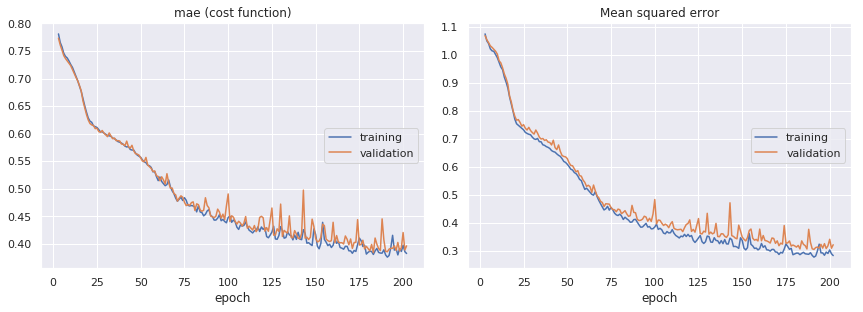

mae (cost function):
training   (min:    0.375, max:    0.806, cur:    0.382)
validation (min:    0.384, max:    0.803, cur:    0.396)

Mean squared error:
training   (min:    0.278, max:    1.116, cur:    0.284)
validation (min:    0.306, max:    1.111, cur:    0.322)
Epoch 203/500


In [0]:
model.fit(
    X_dl_train, y_dl_train, 
    batch_size=1024, 
    epochs=500, 
    validation_data=(X_dl_test, y_dl_test), 
    callbacks=[PlotLossesCallback(dynamic_x_axis=True)]
)

pred = model.predict(X_dl_test)
evaluate_results(y_dl_test, pred.flatten())